In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler
from ofrl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [5]:
from ofrl.utils import OldGymAPIWrapper
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy


In [6]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL as CQL

In [7]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
# basic estimators
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR
# self normalized estimators
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import DiscreteStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import DiscreteStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import DiscreteStateMarginalImportanceSampling as SMIS
from ofrl.ope import DiscreteStateMarginalDoublyRobust as SMDR
from ofrl.ope import DiscreteStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import DiscreteStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import DiscreteStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import DiscreteStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import DiscreteDoubleReinforcementLearning as DRL

In [8]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [9]:

# n_actionss_list = [5, 10, 20, 40, 60, 80]
n_actionss_list = [5, 10, 15, 20, 25]

# random_state_list = [10, 20, 30]
# random_state_list = [100, 200, 300]
random_state_list = [10, 20, 30, 40, 50, 60]
bias_df_list = []
variance_df_list = []
mse_df_list = []

bias_result_df = DataFrame()
variance_result_df = DataFrame()
mse_result_df = DataFrame()


In [10]:

for n_actions in n_actionss_list:
    # standardized environment for discrete action
    env = gym.make("BasicEnv-discrete-v0", n_actions=n_actions)
    # for api compatibility to d3rlpy
    env_ = OldGymAPIWrapper(env)
    # behavior policy
    # start training
    # model
    ddqn = DoubleDQN(
        encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        q_func_factory=MeanQFunctionFactory(),
        target_update_interval=100,
        use_gpu=torch.cuda.is_available(),
    )
    # replay buffer
    buffer = ReplayBuffer(
        maxlen=10000,
        env=env_,
    )
    # explorers
    explorer = LinearDecayEpsilonGreedy(
        start_epsilon=1.0,
        end_epsilon=0.1,
        duration=1000,
    )

    # start training
    # skip if there is a pre-trained model
    ddqn.fit_online(
        env_,
        buffer,
        explorer=explorer,
        eval_env=env_,
        n_steps=100000,
        n_steps_per_epoch=1000,
        update_start_step=1000,
    )

    cql_data = DataFrame()
    sac_data = DataFrame()
    for random_state in random_state_list:

        behavior_policy = EpsilonGreedyHead(
            ddqn, 
            n_actions=env.action_space.n,
            epsilon=0.3,
            name="ddqn_epsilon_0.3",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            max_episode_steps=env.step_per_episode,
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            n_trajectories=10000, 
            obtain_info=False,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            n_trajectories=10000, 
            obtain_info=False,
            random_state=random_state + 1,
        )

        # with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(train_logged_dataset, f)
        # with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(test_logged_dataset, f)

        # with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
        # train_logged_dataset = pickle.load(f)
        # with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
        # test_logged_dataset = pickle.load(f)

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=True,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # Use Conservative Q-Learning policy
        cql = CQL(
            encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            q_func_factory=MeanQFunctionFactory(),
            use_gpu=torch.cuda.is_available(),
        )

        cql.fit(
            train_episodes,
            eval_episodes=test_episodes,
            n_steps=10000,
            scorers={},
        )



        # # save model
        # cql.save_model("d3rlpy_logs/cql_continuous.pt")

        # # reload model
        # cql.build_with_env(env)
        # cql.load_model("d3rlpy_logs/cql_continuous.pt")

        # define evaluation policies (should be deterministic policy)
        cql_ = EpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
        ddqn_ = EpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
        evaluation_policies = [cql_, ddqn_]
                
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            sigma=0.1,
            gamma=0.95,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
        # pickle.dump(input_dict, f)

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
        # input_dict = pickle.load(f)

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        tmp_cql = DataFrame(policy_value_dict)['cql']
        cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        # tmp_sac = DataFrame(policy_value_dict)['sac']
        # sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    # bias = abs(sac_data.mean(axis=1) - sac_data.mean(axis=1)['on_policy'])
    # variance = sac_data.var(axis=1)
    bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    variance = cql_data.var(axis=1)
    mse = bias**2 + variance

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={0: "bias"})
    bias_df["n_actions"] = n_actions
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={0: "variance"})
    variance_df["n_actions"] = n_actions
    variance_df_list.append(variance_df)
    mse_df = DataFrame(DataFrame(mse).stack())\
        .reset_index(1).rename(columns={0: "mse"})
    mse_df["n_actions"] = n_actions
    mse_df_list.append(mse_df)


    # bias_df[n_trajectories] = bias
    # variance_df[n_trajectories] = variance

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

2023-04-06 12:00.12 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230406120012
2023-04-06 12:00.12 [debug    ] Building model...
2023-04-06 12:00.12 [debug    ] Model has been built.
2023-04-06 12:00.12 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406120012/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-04-06 12:00.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406120012/model_1000.pt
2023-04-06 12:00.12 [info     ] DoubleDQN_online_20230406120012: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0002747185230255127, 'time_environment_step': 5.741000175476074e-05, 'time_step': 0.00034981727600097656, 'rollout_return': -0.06537132159943537, 'evaluation': 0.9140159945250987} step=1000
2023-04-06 12:00.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406120012/model_2000.pt
2023-04-06 12:00.14 [info     ] DoubleDQN_online_20230406120012: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00023915290832519532, 'time_environment_step': 5.903029441833496e-05, 'time_sample_batch': 4.994344711303711e-05, 'time_algorithm_update': 0.001115530014038086, 'loss': 0.06052437738794834, 'time_step': 0.001493802785873413, 'rollout_return': 2.6205145247649937, 'evaluation': 3.0354280700592216} step=2000
2023-04-06 12:00.16 [in

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:04.27 [debug    ] RandomIterator is selected.
2023-04-06 12:04.27 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406120427
2023-04-06 12:04.27 [debug    ] Building models...
2023-04-06 12:04.27 [debug    ] Models have been built.
2023-04-06 12:04.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406120427/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:04.43 [info     ] DiscreteCQL_20230406120427: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00010907137393951416, 'time_algorithm_update': 0.0013497818946838379, 'loss': 1.2840593886911869, 'time_step': 0.0015518916845321654} step=10000
2023-04-06 12:04.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406120427/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:04.43 [debug    ] RoundIterator is selected.
2023-04-06 12:04.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406120443
2023-04-06 12:04.43 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:04.43 [debug    ] Building models...
2023-04-06 12:04.43 [debug    ] Models have been built.
2023-04-06 12:04.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120443/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:04.45 [info     ] DiscreteFQE_20230406120443: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015064215660095216, 'time_algorithm_update': 0.0018616597652435303, 'loss': 0.043567356220446524, 'time_step': 0.002118520975112915} step=1000
2023-04-06 12:04.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120443/model_1000.pt
2023-04-06 12:04.45 [debug    ] RoundIterator is selected.
2023-04-06 12:04.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406120445
2023-04-06 12:04.45 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:04.45 [debug    ] Building models...
2023-04-06 12:04.45 [debug    ] Models have been built.
2023-04-06 12:04.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120445/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:04.47 [info     ] DiscreteFQE_20230406120445: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014463090896606445, 'time_algorithm_update': 0.0017683446407318116, 'loss': 0.05107857251353562, 'time_step': 0.0020054850578308104} step=1000
2023-04-06 12:04.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120445/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/weight_value_learning/minimax_weight_learning_discrete.py:153: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  importance_weight = importance_weight @ importance_weight.T


[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:06.49 [debug    ] RandomIterator is selected.
2023-04-06 12:06.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406120649
2023-04-06 12:06.49 [debug    ] Building models...
2023-04-06 12:06.49 [debug    ] Models have been built.
2023-04-06 12:06.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406120649/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:07.06 [info     ] DiscreteCQL_20230406120649: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011542191505432129, 'time_algorithm_update': 0.0014649706602096557, 'loss': 1.283438780015707, 'time_step': 0.0016797560691833495} step=10000
2023-04-06 12:07.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406120649/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:07.06 [debug    ] RoundIterator is selected.
2023-04-06 12:07.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406120706
2023-04-06 12:07.06 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:07.06 [debug    ] Building models...
2023-04-06 12:07.06 [debug    ] Models have been built.
2023-04-06 12:07.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120706/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:07.08 [info     ] DiscreteFQE_20230406120706: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014630508422851563, 'time_algorithm_update': 0.0018094241619110107, 'loss': 0.053269614743068815, 'time_step': 0.00208026385307312} step=1000
2023-04-06 12:07.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120706/model_1000.pt
2023-04-06 12:07.08 [debug    ] RoundIterator is selected.
2023-04-06 12:07.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406120708
2023-04-06 12:07.08 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:07.08 [debug    ] Building models...
2023-04-06 12:07.08 [debug    ] Models have been built.
2023-04-06 12:07.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120708/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:07.10 [info     ] DiscreteFQE_20230406120708: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016059398651123048, 'time_algorithm_update': 0.0018025970458984376, 'loss': 0.06089982284978032, 'time_step': 0.002051711082458496} step=1000
2023-04-06 12:07.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120708/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:09.15 [debug    ] RandomIterator is selected.
2023-04-06 12:09.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406120915
2023-04-06 12:09.15 [debug    ] Building models...
2023-04-06 12:09.15 [debug    ] Models have been built.
2023-04-06 12:09.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406120915/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:09.30 [info     ] DiscreteCQL_20230406120915: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00010714311599731446, 'time_algorithm_update': 0.001309087085723877, 'loss': 1.3109179483056068, 'time_step': 0.0015054511070251464} step=10000
2023-04-06 12:09.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406120915/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:09.30 [debug    ] RoundIterator is selected.
2023-04-06 12:09.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406120930
2023-04-06 12:09.30 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:09.30 [debug    ] Building models...
2023-04-06 12:09.30 [debug    ] Models have been built.
2023-04-06 12:09.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120930/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:09.32 [info     ] DiscreteFQE_20230406120930: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00012435364723205566, 'time_algorithm_update': 0.00128365159034729, 'loss': 0.04628085643239319, 'time_step': 0.0014738876819610596} step=1000
2023-04-06 12:09.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120930/model_1000.pt
2023-04-06 12:09.32 [debug    ] RoundIterator is selected.
2023-04-06 12:09.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406120932
2023-04-06 12:09.32 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:09.32 [debug    ] Building models...
2023-04-06 12:09.32 [debug    ] Models have been built.
2023-04-06 12:09.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120932/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:09.34 [info     ] DiscreteFQE_20230406120932: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013741445541381835, 'time_algorithm_update': 0.001587651491165161, 'loss': 0.04768622201494872, 'time_step': 0.0018045916557312012} step=1000
2023-04-06 12:09.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406120932/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:11.42 [debug    ] RandomIterator is selected.
2023-04-06 12:11.42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406121142
2023-04-06 12:11.42 [debug    ] Building models...
2023-04-06 12:11.42 [debug    ] Models have been built.
2023-04-06 12:11.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406121142/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:11.58 [info     ] DiscreteCQL_20230406121142: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011196532249450684, 'time_algorithm_update': 0.0014060052633285522, 'loss': 1.297982324528694, 'time_step': 0.001614509391784668} step=10000
2023-04-06 12:11.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406121142/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:11.59 [debug    ] RoundIterator is selected.
2023-04-06 12:11.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406121159
2023-04-06 12:11.59 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:11.59 [debug    ] Building models...
2023-04-06 12:11.59 [debug    ] Models have been built.
2023-04-06 12:11.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121159/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:12.01 [info     ] DiscreteFQE_20230406121159: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014711356163024902, 'time_algorithm_update': 0.001810741424560547, 'loss': 0.06689794207550585, 'time_step': 0.002044377326965332} step=1000
2023-04-06 12:12.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121159/model_1000.pt
2023-04-06 12:12.01 [debug    ] RoundIterator is selected.
2023-04-06 12:12.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406121201
2023-04-06 12:12.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:12.01 [debug    ] Building models...
2023-04-06 12:12.01 [debug    ] Models have been built.
2023-04-06 12:12.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121201/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:12.03 [info     ] DiscreteFQE_20230406121201: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015181612968444825, 'time_algorithm_update': 0.001747023105621338, 'loss': 0.058214177830144764, 'time_step': 0.001991410255432129} step=1000
2023-04-06 12:12.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121201/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:14.22 [debug    ] RandomIterator is selected.
2023-04-06 12:14.22 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406121422
2023-04-06 12:14.22 [debug    ] Building models...
2023-04-06 12:14.22 [debug    ] Models have been built.
2023-04-06 12:14.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406121422/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:14.39 [info     ] DiscreteCQL_20230406121422: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0001132680892944336, 'time_algorithm_update': 0.0014342357873916626, 'loss': 1.291869160401821, 'time_step': 0.0016446618318557739} step=10000
2023-04-06 12:14.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406121422/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:14.39 [debug    ] RoundIterator is selected.
2023-04-06 12:14.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406121439
2023-04-06 12:14.39 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:14.39 [debug    ] Building models...
2023-04-06 12:14.39 [debug    ] Models have been built.
2023-04-06 12:14.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121439/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:14.41 [info     ] DiscreteFQE_20230406121439: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013753676414489746, 'time_algorithm_update': 0.001678337335586548, 'loss': 0.044150752626359466, 'time_step': 0.001899399995803833} step=1000
2023-04-06 12:14.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121439/model_1000.pt
2023-04-06 12:14.41 [debug    ] RoundIterator is selected.
2023-04-06 12:14.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406121441
2023-04-06 12:14.41 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:14.41 [debug    ] Building models...
2023-04-06 12:14.41 [debug    ] Models have been built.
2023-04-06 12:14.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121441/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:14.43 [info     ] DiscreteFQE_20230406121441: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016158175468444823, 'time_algorithm_update': 0.0016162731647491454, 'loss': 0.04563004666008055, 'time_step': 0.001875093936920166} step=1000
2023-04-06 12:14.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121441/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:16.40 [debug    ] RandomIterator is selected.
2023-04-06 12:16.40 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406121640
2023-04-06 12:16.40 [debug    ] Building models...
2023-04-06 12:16.40 [debug    ] Models have been built.
2023-04-06 12:16.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406121640/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:16.56 [info     ] DiscreteCQL_20230406121640: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00010920031070709228, 'time_algorithm_update': 0.0013788613557815551, 'loss': 1.2858657442331314, 'time_step': 0.0015841424226760864} step=10000
2023-04-06 12:16.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406121640/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:16.57 [debug    ] RoundIterator is selected.
2023-04-06 12:16.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406121657
2023-04-06 12:16.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:16.57 [debug    ] Building models...
2023-04-06 12:16.57 [debug    ] Models have been built.
2023-04-06 12:16.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121657/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:16.58 [info     ] DiscreteFQE_20230406121657: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013103771209716796, 'time_algorithm_update': 0.0015203425884246827, 'loss': 0.049179365394636985, 'time_step': 0.0017236292362213135} step=1000
2023-04-06 12:16.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121657/model_1000.pt
2023-04-06 12:16.58 [debug    ] RoundIterator is selected.
2023-04-06 12:16.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406121658
2023-04-06 12:16.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:16.58 [debug    ] Building models...
2023-04-06 12:16.58 [debug    ] Models have been built.
2023-04-06 12:16.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121658/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dr

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:17.01 [info     ] DiscreteFQE_20230406121658: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015890669822692872, 'time_algorithm_update': 0.001711902618408203, 'loss': 0.04939390995539725, 'time_step': 0.0019621500968933104} step=1000
2023-04-06 12:17.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406121658/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 12:17.39 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230406121739
2023-04-06 12:17.39 [debug    ] Building model...
2023-04-06 12:17.39 [debug    ] Model has been built.
2023-04-06 12:17.39 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406121739/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator
/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-04-06 12:17.39 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406121739/model_1000.pt
2023-04-06 12:17.39 [info     ] DoubleDQN_online_20230406121739: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00028515362739562987, 'time_environment_step': 5.0439119338989255e-05, 'time_step': 0.00034985995292663577, 'rollout_return': 2.8026638230547203, 'evaluation': 4.6534156042194335} step=1000
2023-04-06 12:17.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406121739/model_2000.pt
2023-04-06 12:17.41 [info     ] DoubleDQN_online_20230406121739: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0002111070156097412, 'time_environment_step': 5.218029022216797e-05, 'time_sample_batch': 4.285407066345215e-05, 'time_algorithm_update': 0.0009600639343261719, 'loss': 0.13884640462324024, 'time_step': 0.0012913796901702882, 'rollout_return': 4.301295325091499, 'evaluation': 4.754479026969912} step=2000
2023-04-06 12:17.42 [inf

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:21.46 [debug    ] RandomIterator is selected.
2023-04-06 12:21.46 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406122146
2023-04-06 12:21.46 [debug    ] Building models...
2023-04-06 12:21.46 [debug    ] Models have been built.
2023-04-06 12:21.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406122146/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:22.02 [info     ] DiscreteCQL_20230406122146: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011171936988830566, 'time_algorithm_update': 0.0014239136695861816, 'loss': 1.8014619823932647, 'time_step': 0.001636495041847229} step=10000
2023-04-06 12:22.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406122146/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:22.02 [debug    ] RoundIterator is selected.
2023-04-06 12:22.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406122202
2023-04-06 12:22.02 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:22.02 [debug    ] Building models...
2023-04-06 12:22.02 [debug    ] Models have been built.
2023-04-06 12:22.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122202/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:22.04 [info     ] DiscreteFQE_20230406122202: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014481067657470703, 'time_algorithm_update': 0.0015937931537628174, 'loss': 0.2657528602555394, 'time_step': 0.0018307175636291504} step=1000
2023-04-06 12:22.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122202/model_1000.pt
2023-04-06 12:22.04 [debug    ] RoundIterator is selected.
2023-04-06 12:22.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406122204
2023-04-06 12:22.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:22.04 [debug    ] Building models...
2023-04-06 12:22.04 [debug    ] Models have been built.
2023-04-06 12:22.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122204/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:22.06 [info     ] DiscreteFQE_20230406122204: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014534235000610352, 'time_algorithm_update': 0.0017274672985076905, 'loss': 0.20577421245723962, 'time_step': 0.0019512908458709716} step=1000
2023-04-06 12:22.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122204/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:24.09 [debug    ] RandomIterator is selected.
2023-04-06 12:24.09 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406122409
2023-04-06 12:24.09 [debug    ] Building models...
2023-04-06 12:24.09 [debug    ] Models have been built.
2023-04-06 12:24.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406122409/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:24.26 [info     ] DiscreteCQL_20230406122409: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011391527652740478, 'time_algorithm_update': 0.001486434555053711, 'loss': 1.7926628483891487, 'time_step': 0.0017055917978286742} step=10000
2023-04-06 12:24.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406122409/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:24.26 [debug    ] RoundIterator is selected.
2023-04-06 12:24.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406122426
2023-04-06 12:24.26 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:24.26 [debug    ] Building models...
2023-04-06 12:24.26 [debug    ] Models have been built.
2023-04-06 12:24.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122426/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:24.28 [info     ] DiscreteFQE_20230406122426: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00012871742248535156, 'time_algorithm_update': 0.0014790775775909424, 'loss': 0.2205328686311841, 'time_step': 0.0016721696853637695} step=1000
2023-04-06 12:24.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122426/model_1000.pt
2023-04-06 12:24.28 [debug    ] RoundIterator is selected.
2023-04-06 12:24.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406122428
2023-04-06 12:24.28 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:24.28 [debug    ] Building models...
2023-04-06 12:24.28 [debug    ] Models have been built.
2023-04-06 12:24.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122428/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:24.30 [info     ] DiscreteFQE_20230406122428: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.000139723539352417, 'time_algorithm_update': 0.0014520411491394042, 'loss': 0.2554878071397543, 'time_step': 0.0016598505973815917} step=1000
2023-04-06 12:24.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406122428/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:58.30 [debug    ] RandomIterator is selected.
2023-04-06 12:58.30 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406125830
2023-04-06 12:58.30 [debug    ] Building models...
2023-04-06 12:58.30 [debug    ] Models have been built.
2023-04-06 12:58.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406125830/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 12:58.42 [info     ] DiscreteCQL_20230406125830: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.545444965362549e-05, 'time_algorithm_update': 0.001011796283721924, 'loss': 1.8101801388978958, 'time_step': 0.0011504390239715577} step=10000
2023-04-06 12:58.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406125830/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 12:58.42 [debug    ] RoundIterator is selected.
2023-04-06 12:58.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406125842
2023-04-06 12:58.42 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:58.42 [debug    ] Building models...
2023-04-06 12:58.42 [debug    ] Models have been built.
2023-04-06 12:58.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406125842/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:58.43 [info     ] DiscreteFQE_20230406125842: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.984041213989257e-05, 'time_algorithm_update': 0.0008619418144226074, 'loss': 0.2058429387062788, 'time_step': 0.0009899203777313233} step=1000
2023-04-06 12:58.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406125842/model_1000.pt
2023-04-06 12:58.43 [debug    ] RoundIterator is selected.
2023-04-06 12:58.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406125843
2023-04-06 12:58.43 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 12:58.43 [debug    ] Building models...
2023-04-06 12:58.43 [debug    ] Models have been built.
2023-04-06 12:58.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406125843/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 12:58.44 [info     ] DiscreteFQE_20230406125843: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.97519588470459e-05, 'time_algorithm_update': 0.0008770503997802734, 'loss': 0.20271955270320177, 'time_step': 0.001005770206451416} step=1000
2023-04-06 12:58.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406125843/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:00.32 [debug    ] RandomIterator is selected.
2023-04-06 13:00.32 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406130032
2023-04-06 13:00.32 [debug    ] Building models...
2023-04-06 13:00.32 [debug    ] Models have been built.
2023-04-06 13:00.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406130032/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:00.47 [info     ] DiscreteCQL_20230406130032: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00010287213325500488, 'time_algorithm_update': 0.0012833104133605957, 'loss': 1.7888326598644257, 'time_step': 0.0014731208801269532} step=10000
2023-04-06 13:00.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406130032/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:00.47 [debug    ] RoundIterator is selected.
2023-04-06 13:00.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406130047
2023-04-06 13:00.47 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:00.47 [debug    ] Building models...
2023-04-06 13:00.47 [debug    ] Models have been built.
2023-04-06 13:00.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130047/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:00.49 [info     ] DiscreteFQE_20230406130047: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00011700057983398437, 'time_algorithm_update': 0.0012309575080871583, 'loss': 0.2206470279544592, 'time_step': 0.0014029529094696045} step=1000
2023-04-06 13:00.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130047/model_1000.pt
2023-04-06 13:00.49 [debug    ] RoundIterator is selected.
2023-04-06 13:00.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406130049
2023-04-06 13:00.49 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:00.49 [debug    ] Building models...
2023-04-06 13:00.49 [debug    ] Models have been built.
2023-04-06 13:00.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130049/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:00.50 [info     ] DiscreteFQE_20230406130049: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001111454963684082, 'time_algorithm_update': 0.0011202702522277832, 'loss': 0.203216513261199, 'time_step': 0.0012818329334259033} step=1000
2023-04-06 13:00.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130049/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:02.42 [debug    ] RandomIterator is selected.
2023-04-06 13:02.42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406130242
2023-04-06 13:02.42 [debug    ] Building models...
2023-04-06 13:02.42 [debug    ] Models have been built.
2023-04-06 13:02.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406130242/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:02.57 [info     ] DiscreteCQL_20230406130242: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00010400154590606689, 'time_algorithm_update': 0.0012684848308563233, 'loss': 1.7956870667159557, 'time_step': 0.001457714581489563} step=10000
2023-04-06 13:02.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406130242/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:02.57 [debug    ] RoundIterator is selected.
2023-04-06 13:02.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406130257
2023-04-06 13:02.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:02.57 [debug    ] Building models...
2023-04-06 13:02.57 [debug    ] Models have been built.
2023-04-06 13:02.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130257/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:02.58 [info     ] DiscreteFQE_20230406130257: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00011318945884704589, 'time_algorithm_update': 0.0011898369789123534, 'loss': 0.19999540699273347, 'time_step': 0.0013511252403259277} step=1000
2023-04-06 13:02.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130257/model_1000.pt
2023-04-06 13:02.58 [debug    ] RoundIterator is selected.
2023-04-06 13:02.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406130258
2023-04-06 13:02.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:02.58 [debug    ] Building models...
2023-04-06 13:02.58 [debug    ] Models have been built.
2023-04-06 13:02.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130258/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:03.00 [info     ] DiscreteFQE_20230406130258: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013343524932861328, 'time_algorithm_update': 0.0012822585105895996, 'loss': 0.2403086522296071, 'time_step': 0.0014737136363983155} step=1000
2023-04-06 13:03.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130258/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:04.54 [debug    ] RandomIterator is selected.
2023-04-06 13:04.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406130454
2023-04-06 13:04.54 [debug    ] Building models...
2023-04-06 13:04.54 [debug    ] Models have been built.
2023-04-06 13:04.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406130454/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:05.10 [info     ] DiscreteCQL_20230406130454: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011006934642791749, 'time_algorithm_update': 0.0013526087045669555, 'loss': 1.814650018775463, 'time_step': 0.001556123447418213} step=10000
2023-04-06 13:05.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406130454/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:05.10 [debug    ] RoundIterator is selected.
2023-04-06 13:05.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406130510
2023-04-06 13:05.10 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:05.10 [debug    ] Building models...
2023-04-06 13:05.10 [debug    ] Models have been built.
2023-04-06 13:05.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130510/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:05.12 [info     ] DiscreteFQE_20230406130510: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00012618517875671387, 'time_algorithm_update': 0.0013173205852508546, 'loss': 0.23932779743522406, 'time_step': 0.0015039808750152588} step=1000
2023-04-06 13:05.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130510/model_1000.pt
2023-04-06 13:05.12 [debug    ] RoundIterator is selected.
2023-04-06 13:05.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406130512
2023-04-06 13:05.12 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:05.12 [debug    ] Building models...
2023-04-06 13:05.12 [debug    ] Models have been built.
2023-04-06 13:05.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130512/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:05.14 [info     ] DiscreteFQE_20230406130512: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013082218170166015, 'time_algorithm_update': 0.0013432905673980713, 'loss': 0.21294599483162166, 'time_step': 0.0015349392890930177} step=1000
2023-04-06 13:05.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406130512/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


2023-04-06 13:05.59 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230406130559
2023-04-06 13:05.59 [debug    ] Building model...
2023-04-06 13:05.59 [debug    ] Model has been built.
2023-04-06 13:05.59 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406130559/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-04-06 13:06.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406130559/model_1000.pt
2023-04-06 13:06.00 [info     ] DoubleDQN_online_20230406130559: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0002780742645263672, 'time_environment_step': 5.830860137939453e-05, 'time_step': 0.00035440611839294436, 'rollout_return': 0.10233357867116083, 'evaluation': 0.48795834316958187} step=1000
2023-04-06 13:06.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406130559/model_2000.pt
2023-04-06 13:06.01 [info     ] DoubleDQN_online_20230406130559: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0002685773372650146, 'time_environment_step': 6.431198120117188e-05, 'time_sample_batch': 5.200862884521484e-05, 'time_algorithm_update': 0.001178436517715454, 'loss': 0.05989251937158406, 'time_step': 0.0015946118831634522, 'rollout_return': 0.8125574370365775, 'evaluation': 2.861732432872175} step=2000
2023-04-06 13:06.03 [inf

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:10.27 [debug    ] RandomIterator is selected.
2023-04-06 13:10.27 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406131027
2023-04-06 13:10.27 [debug    ] Building models...
2023-04-06 13:10.27 [debug    ] Models have been built.
2023-04-06 13:10.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406131027/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:10.47 [info     ] DiscreteCQL_20230406131027: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00013958613872528075, 'time_algorithm_update': 0.0017695564031600952, 'loss': 1.9265155671536922, 'time_step': 0.002027824878692627} step=10000
2023-04-06 13:10.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406131027/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:10.48 [debug    ] RoundIterator is selected.
2023-04-06 13:10.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406131048
2023-04-06 13:10.48 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:10.48 [debug    ] Building models...
2023-04-06 13:10.48 [debug    ] Models have been built.
2023-04-06 13:10.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131048/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:10.50 [info     ] DiscreteFQE_20230406131048: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00018234944343566893, 'time_algorithm_update': 0.0017007775306701661, 'loss': 0.2684076359421015, 'time_step': 0.0019732608795166016} step=1000
2023-04-06 13:10.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131048/model_1000.pt
2023-04-06 13:10.50 [debug    ] RoundIterator is selected.
2023-04-06 13:10.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406131050
2023-04-06 13:10.50 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:10.50 [debug    ] Building models...
2023-04-06 13:10.50 [debug    ] Models have been built.
2023-04-06 13:10.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131050/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:10.52 [info     ] DiscreteFQE_20230406131050: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016608047485351562, 'time_algorithm_update': 0.0018060343265533447, 'loss': 0.3218949088305235, 'time_step': 0.002058647394180298} step=1000
2023-04-06 13:10.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131050/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:13.32 [debug    ] RandomIterator is selected.
2023-04-06 13:13.32 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406131332
2023-04-06 13:13.32 [debug    ] Building models...
2023-04-06 13:13.32 [debug    ] Models have been built.
2023-04-06 13:13.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406131332/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:13.53 [info     ] DiscreteCQL_20230406131332: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00013962137699127198, 'time_algorithm_update': 0.0017571816682815551, 'loss': 1.9164795878648757, 'time_step': 0.0020141547918319704} step=10000
2023-04-06 13:13.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406131332/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:13.53 [debug    ] RoundIterator is selected.
2023-04-06 13:13.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406131353
2023-04-06 13:13.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:13.53 [debug    ] Building models...
2023-04-06 13:13.53 [debug    ] Models have been built.
2023-04-06 13:13.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131353/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:13.55 [info     ] DiscreteFQE_20230406131353: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001617119312286377, 'time_algorithm_update': 0.0017331445217132568, 'loss': 0.32593057061731817, 'time_step': 0.0019754559993743898} step=1000
2023-04-06 13:13.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131353/model_1000.pt
2023-04-06 13:13.55 [debug    ] RoundIterator is selected.
2023-04-06 13:13.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406131355
2023-04-06 13:13.55 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:13.55 [debug    ] Building models...
2023-04-06 13:13.55 [debug    ] Models have been built.
2023-04-06 13:13.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131355/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:13.57 [info     ] DiscreteFQE_20230406131355: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00015943455696105957, 'time_algorithm_update': 0.0016350877285003663, 'loss': 0.32963313069939615, 'time_step': 0.0018684298992156982} step=1000
2023-04-06 13:13.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406131355/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:31.39 [debug    ] RandomIterator is selected.
2023-04-06 13:31.39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406133139
2023-04-06 13:31.39 [debug    ] Building models...
2023-04-06 13:31.39 [debug    ] Models have been built.
2023-04-06 13:31.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406133139/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:31.50 [info     ] DiscreteCQL_20230406133139: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.525219917297364e-05, 'time_algorithm_update': 0.0010293154954910278, 'loss': 1.8663149156451224, 'time_step': 0.0011687113285064697} step=10000
2023-04-06 13:31.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406133139/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:31.51 [debug    ] RoundIterator is selected.
2023-04-06 13:31.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406133151
2023-04-06 13:31.51 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:31.51 [debug    ] Building models...
2023-04-06 13:31.51 [debug    ] Models have been built.
2023-04-06 13:31.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406133151/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:31.52 [info     ] DiscreteFQE_20230406133151: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.19783115386963e-05, 'time_algorithm_update': 0.0009235563278198242, 'loss': 0.28144328138977287, 'time_step': 0.001057399034500122} step=1000
2023-04-06 13:31.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406133151/model_1000.pt
2023-04-06 13:31.52 [debug    ] RoundIterator is selected.
2023-04-06 13:31.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406133152
2023-04-06 13:31.52 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:31.52 [debug    ] Building models...
2023-04-06 13:31.52 [debug    ] Models have been built.
2023-04-06 13:31.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406133152/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:31.53 [info     ] DiscreteFQE_20230406133152: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.413552284240723e-05, 'time_algorithm_update': 0.0009555981159210205, 'loss': 0.2754204522669315, 'time_step': 0.0010940983295440673} step=1000
2023-04-06 13:31.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406133152/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:39.51 [debug    ] RandomIterator is selected.
2023-04-06 13:39.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406133951
2023-04-06 13:39.51 [debug    ] Building models...
2023-04-06 13:39.51 [debug    ] Models have been built.
2023-04-06 13:39.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406133951/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:40.03 [info     ] DiscreteCQL_20230406133951: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.71437406539917e-05, 'time_algorithm_update': 0.0010736918687820434, 'loss': 1.8886292767584323, 'time_step': 0.0012214064359664916} step=10000
2023-04-06 13:40.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406133951/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:40.03 [debug    ] RoundIterator is selected.
2023-04-06 13:40.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134003
2023-04-06 13:40.03 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:40.03 [debug    ] Building models...
2023-04-06 13:40.03 [debug    ] Models have been built.
2023-04-06 13:40.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134003/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:40.04 [info     ] DiscreteFQE_20230406134003: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.08513069152832e-05, 'time_algorithm_update': 0.0009055805206298829, 'loss': 0.3450462814643979, 'time_step': 0.0010413389205932617} step=1000
2023-04-06 13:40.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134003/model_1000.pt
2023-04-06 13:40.04 [debug    ] RoundIterator is selected.
2023-04-06 13:40.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134004
2023-04-06 13:40.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:40.04 [debug    ] Building models...
2023-04-06 13:40.04 [debug    ] Models have been built.
2023-04-06 13:40.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134004/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:40.06 [info     ] DiscreteFQE_20230406134004: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.467339515686035e-05, 'time_algorithm_update': 0.0009710819721221924, 'loss': 0.351951535820961, 'time_step': 0.0011145281791687012} step=1000
2023-04-06 13:40.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134004/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:41.31 [debug    ] RandomIterator is selected.
2023-04-06 13:41.31 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406134131
2023-04-06 13:41.31 [debug    ] Building models...
2023-04-06 13:41.31 [debug    ] Models have been built.
2023-04-06 13:41.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134131/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:41.42 [info     ] DiscreteCQL_20230406134131: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.850914001464844e-05, 'time_algorithm_update': 0.0010196136951446534, 'loss': 1.9093804156959058, 'time_step': 0.001168279242515564} step=10000
2023-04-06 13:41.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134131/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:41.43 [debug    ] RoundIterator is selected.
2023-04-06 13:41.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134143
2023-04-06 13:41.43 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:41.43 [debug    ] Building models...
2023-04-06 13:41.43 [debug    ] Models have been built.
2023-04-06 13:41.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134143/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:41.44 [info     ] DiscreteFQE_20230406134143: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010091042518615723, 'time_algorithm_update': 0.000978567361831665, 'loss': 0.27098274885863066, 'time_step': 0.001126349925994873} step=1000
2023-04-06 13:41.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134143/model_1000.pt
2023-04-06 13:41.44 [debug    ] RoundIterator is selected.
2023-04-06 13:41.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134144
2023-04-06 13:41.44 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:41.44 [debug    ] Building models...
2023-04-06 13:41.44 [debug    ] Models have been built.
2023-04-06 13:41.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134144/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:41.45 [info     ] DiscreteFQE_20230406134144: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.255671501159668e-05, 'time_algorithm_update': 0.000910315752029419, 'loss': 0.29505266854166984, 'time_step': 0.0010482499599456787} step=1000
2023-04-06 13:41.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134144/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:43.12 [debug    ] RandomIterator is selected.
2023-04-06 13:43.12 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406134312
2023-04-06 13:43.12 [debug    ] Building models...
2023-04-06 13:43.12 [debug    ] Models have been built.
2023-04-06 13:43.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134312/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:43.24 [info     ] DiscreteCQL_20230406134312: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.929503917694091e-05, 'time_algorithm_update': 0.0010493300199508667, 'loss': 1.9043168354332447, 'time_step': 0.0012003181457519532} step=10000
2023-04-06 13:43.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134312/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:43.25 [debug    ] RoundIterator is selected.
2023-04-06 13:43.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134325
2023-04-06 13:43.25 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:43.25 [debug    ] Building models...
2023-04-06 13:43.25 [debug    ] Models have been built.
2023-04-06 13:43.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134325/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:43.26 [info     ] DiscreteFQE_20230406134325: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.716200828552246e-05, 'time_algorithm_update': 0.0009284446239471436, 'loss': 0.28882819442451, 'time_step': 0.0010729336738586426} step=1000
2023-04-06 13:43.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134325/model_1000.pt
2023-04-06 13:43.26 [debug    ] RoundIterator is selected.
2023-04-06 13:43.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134326
2023-04-06 13:43.26 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:43.26 [debug    ] Building models...
2023-04-06 13:43.26 [debug    ] Models have been built.
2023-04-06 13:43.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134326/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:43.27 [info     ] DiscreteFQE_20230406134326: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.236502647399902e-05, 'time_algorithm_update': 0.0009399182796478271, 'loss': 0.23958042884618044, 'time_step': 0.001073625087738037} step=1000
2023-04-06 13:43.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134326/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 13:43.59 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230406134359
2023-04-06 13:43.59 [debug    ] Building model...
2023-04-06 13:43.59 [debug    ] Model has been built.
2023-04-06 13:43.59 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406134359/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator
/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-04-06 13:43.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406134359/model_1000.pt
2023-04-06 13:43.59 [info     ] DoubleDQN_online_20230406134359: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00013987421989440917, 'time_environment_step': 3.0167818069458008e-05, 'time_step': 0.00017942261695861816, 'rollout_return': -1.5697792717373429, 'evaluation': -4.549135159713964} step=1000
2023-04-06 13:44.00 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406134359/model_2000.pt
2023-04-06 13:44.00 [info     ] DoubleDQN_online_20230406134359: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00015047359466552733, 'time_environment_step': 3.685498237609863e-05, 'time_sample_batch': 3.18138599395752e-05, 'time_algorithm_update': 0.0006868131160736084, 'loss': 0.08655915959179401, 'time_step': 0.0009238064289093017, 'rollout_return': 0.9114120861729718, 'evaluation': 3.110698273575843} step=2000
2023-04-06 13:44.01 [i

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:46.57 [debug    ] RandomIterator is selected.
2023-04-06 13:46.57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406134657
2023-04-06 13:46.57 [debug    ] Building models...
2023-04-06 13:46.57 [debug    ] Models have been built.
2023-04-06 13:46.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134657/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:47.09 [info     ] DiscreteCQL_20230406134657: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 8.767492771148682e-05, 'time_algorithm_update': 0.0010483191251754761, 'loss': 2.2456714215517044, 'time_step': 0.0012134636163711548} step=10000
2023-04-06 13:47.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134657/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:47.09 [debug    ] RoundIterator is selected.
2023-04-06 13:47.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134709
2023-04-06 13:47.09 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:47.09 [debug    ] Building models...
2023-04-06 13:47.09 [debug    ] Models have been built.
2023-04-06 13:47.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134709/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:47.11 [info     ] DiscreteFQE_20230406134709: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010620689392089844, 'time_algorithm_update': 0.0010554590225219727, 'loss': 0.2716339487656951, 'time_step': 0.0012094616889953614} step=1000
2023-04-06 13:47.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134709/model_1000.pt
2023-04-06 13:47.11 [debug    ] RoundIterator is selected.
2023-04-06 13:47.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134711
2023-04-06 13:47.11 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:47.11 [debug    ] Building models...
2023-04-06 13:47.11 [debug    ] Models have been built.
2023-04-06 13:47.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134711/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:47.12 [info     ] DiscreteFQE_20230406134711: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010227823257446289, 'time_algorithm_update': 0.001026210069656372, 'loss': 0.21322892657667397, 'time_step': 0.0011780550479888916} step=1000
2023-04-06 13:47.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134711/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:48.51 [debug    ] RandomIterator is selected.
2023-04-06 13:48.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406134851
2023-04-06 13:48.51 [debug    ] Building models...
2023-04-06 13:48.51 [debug    ] Models have been built.
2023-04-06 13:48.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134851/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:49.04 [info     ] DiscreteCQL_20230406134851: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 9.092411994934082e-05, 'time_algorithm_update': 0.0011330017805099488, 'loss': 2.218807859325409, 'time_step': 0.0013033153295516967} step=10000
2023-04-06 13:49.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406134851/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:49.04 [debug    ] RoundIterator is selected.
2023-04-06 13:49.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134904
2023-04-06 13:49.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:49.04 [debug    ] Building models...
2023-04-06 13:49.04 [debug    ] Models have been built.
2023-04-06 13:49.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134904/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:49.06 [info     ] DiscreteFQE_20230406134904: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010502266883850098, 'time_algorithm_update': 0.0010115509033203126, 'loss': 0.22902747256308795, 'time_step': 0.0011648280620574951} step=1000
2023-04-06 13:49.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134904/model_1000.pt
2023-04-06 13:49.06 [debug    ] RoundIterator is selected.
2023-04-06 13:49.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406134906
2023-04-06 13:49.06 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:49.06 [debug    ] Building models...
2023-04-06 13:49.06 [debug    ] Models have been built.
2023-04-06 13:49.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134906/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:49.07 [info     ] DiscreteFQE_20230406134906: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010554218292236328, 'time_algorithm_update': 0.0010247573852539063, 'loss': 0.24009297928214074, 'time_step': 0.0011907122135162353} step=1000
2023-04-06 13:49.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406134906/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:50.49 [debug    ] RandomIterator is selected.
2023-04-06 13:50.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406135049
2023-04-06 13:50.49 [debug    ] Building models...
2023-04-06 13:50.49 [debug    ] Models have been built.
2023-04-06 13:50.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135049/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:51.03 [info     ] DiscreteCQL_20230406135049: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 9.313826560974121e-05, 'time_algorithm_update': 0.0011768299102783203, 'loss': 2.215310429096222, 'time_step': 0.0013539377450942993} step=10000
2023-04-06 13:51.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135049/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:51.03 [debug    ] RoundIterator is selected.
2023-04-06 13:51.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135103
2023-04-06 13:51.03 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:51.03 [debug    ] Building models...
2023-04-06 13:51.03 [debug    ] Models have been built.
2023-04-06 13:51.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135103/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:51.04 [info     ] DiscreteFQE_20230406135103: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010590362548828125, 'time_algorithm_update': 0.0010729756355285646, 'loss': 0.2104146259203553, 'time_step': 0.0012278790473937988} step=1000
2023-04-06 13:51.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135103/model_1000.pt
2023-04-06 13:51.04 [debug    ] RoundIterator is selected.
2023-04-06 13:51.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135104
2023-04-06 13:51.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:51.04 [debug    ] Building models...
2023-04-06 13:51.04 [debug    ] Models have been built.
2023-04-06 13:51.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135104/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:51.05 [info     ] DiscreteFQE_20230406135104: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010625481605529786, 'time_algorithm_update': 0.0010801079273223878, 'loss': 0.19691681295633315, 'time_step': 0.0012357676029205323} step=1000
2023-04-06 13:51.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135104/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:52.49 [debug    ] RandomIterator is selected.
2023-04-06 13:52.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406135249
2023-04-06 13:52.49 [debug    ] Building models...
2023-04-06 13:52.49 [debug    ] Models have been built.
2023-04-06 13:52.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135249/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:53.03 [info     ] DiscreteCQL_20230406135249: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 9.26370620727539e-05, 'time_algorithm_update': 0.001156880760192871, 'loss': 2.2488040065765382, 'time_step': 0.0013310741186141968} step=10000
2023-04-06 13:53.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135249/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:53.03 [debug    ] RoundIterator is selected.
2023-04-06 13:53.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135303
2023-04-06 13:53.03 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:53.03 [debug    ] Building models...
2023-04-06 13:53.03 [debug    ] Models have been built.
2023-04-06 13:53.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135303/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:53.04 [info     ] DiscreteFQE_20230406135303: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010790514945983886, 'time_algorithm_update': 0.001163639545440674, 'loss': 0.23678505191206933, 'time_step': 0.0013250198364257813} step=1000
2023-04-06 13:53.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135303/model_1000.pt
2023-04-06 13:53.04 [debug    ] RoundIterator is selected.
2023-04-06 13:53.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135304
2023-04-06 13:53.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:53.04 [debug    ] Building models...
2023-04-06 13:53.04 [debug    ] Models have been built.
2023-04-06 13:53.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135304/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:53.06 [info     ] DiscreteFQE_20230406135304: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010549664497375489, 'time_algorithm_update': 0.0011053192615509033, 'loss': 0.2090519466549158, 'time_step': 0.0012608766555786133} step=1000
2023-04-06 13:53.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135304/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:54.49 [debug    ] RandomIterator is selected.
2023-04-06 13:54.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406135449
2023-04-06 13:54.49 [debug    ] Building models...
2023-04-06 13:54.49 [debug    ] Models have been built.
2023-04-06 13:54.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135449/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:55.02 [info     ] DiscreteCQL_20230406135449: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 9.35232400894165e-05, 'time_algorithm_update': 0.001164583373069763, 'loss': 2.2267220302224158, 'time_step': 0.0013423252820968627} step=10000
2023-04-06 13:55.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135449/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:55.03 [debug    ] RoundIterator is selected.
2023-04-06 13:55.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135503
2023-04-06 13:55.03 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:55.03 [debug    ] Building models...
2023-04-06 13:55.03 [debug    ] Models have been built.
2023-04-06 13:55.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135503/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:55.04 [info     ] DiscreteFQE_20230406135503: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001241602897644043, 'time_algorithm_update': 0.0013401875495910646, 'loss': 0.23636534414440394, 'time_step': 0.0015277564525604248} step=1000
2023-04-06 13:55.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135503/model_1000.pt
2023-04-06 13:55.04 [debug    ] RoundIterator is selected.
2023-04-06 13:55.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135504
2023-04-06 13:55.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:55.04 [debug    ] Building models...
2023-04-06 13:55.04 [debug    ] Models have been built.
2023-04-06 13:55.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135504/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:55.06 [info     ] DiscreteFQE_20230406135504: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00011788177490234375, 'time_algorithm_update': 0.0012027623653411866, 'loss': 0.2190770276784897, 'time_step': 0.0013758995532989501} step=1000
2023-04-06 13:55.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135504/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:56.53 [debug    ] RandomIterator is selected.
2023-04-06 13:56.53 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406135653
2023-04-06 13:56.53 [debug    ] Building models...
2023-04-06 13:56.53 [debug    ] Models have been built.
2023-04-06 13:56.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135653/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 13:57.06 [info     ] DiscreteCQL_20230406135653: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 9.366698265075683e-05, 'time_algorithm_update': 0.0011375932931900023, 'loss': 2.2403152718663217, 'time_step': 0.001313647484779358} step=10000
2023-04-06 13:57.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406135653/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 13:57.06 [debug    ] RoundIterator is selected.
2023-04-06 13:57.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135706
2023-04-06 13:57.06 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:57.06 [debug    ] Building models...
2023-04-06 13:57.06 [debug    ] Models have been built.
2023-04-06 13:57.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135706/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:57.07 [info     ] DiscreteFQE_20230406135706: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00011176705360412598, 'time_algorithm_update': 0.0011355714797973632, 'loss': 0.23920624408125876, 'time_step': 0.0013014061450958253} step=1000
2023-04-06 13:57.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135706/model_1000.pt
2023-04-06 13:57.07 [debug    ] RoundIterator is selected.
2023-04-06 13:57.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406135707
2023-04-06 13:57.07 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 13:57.07 [debug    ] Building models...
2023-04-06 13:57.07 [debug    ] Models have been built.
2023-04-06 13:57.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135707/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 13:57.09 [info     ] DiscreteFQE_20230406135707: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001036837100982666, 'time_algorithm_update': 0.001043125867843628, 'loss': 0.20803925424069167, 'time_step': 0.0011886050701141358} step=1000
2023-04-06 13:57.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406135707/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 13:57.48 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230406135748
2023-04-06 13:57.48 [debug    ] Building model...
2023-04-06 13:57.48 [debug    ] Model has been built.
2023-04-06 13:57.48 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406135748/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator
/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/100000 [00:00<?, ?it/s]

2023-04-06 13:57.48 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406135748/model_1000.pt
2023-04-06 13:57.48 [info     ] DoubleDQN_online_20230406135748: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00018005061149597168, 'time_environment_step': 3.8606166839599606e-05, 'time_step': 0.00023111605644226074, 'rollout_return': -0.8276317036704584, 'evaluation': -1.4590802242382699} step=1000
2023-04-06 13:57.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230406135748/model_2000.pt
2023-04-06 13:57.49 [info     ] DoubleDQN_online_20230406135748: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00018951964378356934, 'time_environment_step': 4.593658447265625e-05, 'time_sample_batch': 4.0824413299560544e-05, 'time_algorithm_update': 0.0009034202098846436, 'loss': 0.14829850108921527, 'time_step': 0.001202493190765381, 'rollout_return': 6.245262312297847, 'evaluation': 9.629655434884002} step=2000
2023-04-06 13:57.50 [

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:01.37 [debug    ] RandomIterator is selected.
2023-04-06 14:01.37 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406140137
2023-04-06 14:01.37 [debug    ] Building models...
2023-04-06 14:01.37 [debug    ] Models have been built.
2023-04-06 14:01.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406140137/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:01.59 [info     ] DiscreteCQL_20230406140137: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00013402271270751952, 'time_algorithm_update': 0.0018783600330352782, 'loss': 2.3957245346426963, 'time_step': 0.0021468517541885375} step=10000
2023-04-06 14:01.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406140137/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:01.59 [debug    ] RoundIterator is selected.
2023-04-06 14:01.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406140159
2023-04-06 14:01.59 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:01.59 [debug    ] Building models...
2023-04-06 14:01.59 [debug    ] Models have been built.
2023-04-06 14:01.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140159/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:02.01 [info     ] DiscreteFQE_20230406140159: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001590113639831543, 'time_algorithm_update': 0.0017886719703674317, 'loss': 0.25202450799942017, 'time_step': 0.0020352602005004883} step=1000
2023-04-06 14:02.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140159/model_1000.pt
2023-04-06 14:02.02 [debug    ] RoundIterator is selected.
2023-04-06 14:02.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406140202
2023-04-06 14:02.02 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:02.02 [debug    ] Building models...
2023-04-06 14:02.02 [debug    ] Models have been built.
2023-04-06 14:02.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140202/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:02.04 [info     ] DiscreteFQE_20230406140202: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014946842193603517, 'time_algorithm_update': 0.0017328703403472901, 'loss': 0.25358506534993647, 'time_step': 0.0019619054794311522} step=1000
2023-04-06 14:02.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140202/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:04.43 [debug    ] RandomIterator is selected.
2023-04-06 14:04.43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406140443
2023-04-06 14:04.43 [debug    ] Building models...
2023-04-06 14:04.43 [debug    ] Models have been built.
2023-04-06 14:04.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406140443/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:05.04 [info     ] DiscreteCQL_20230406140443: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0001366659164428711, 'time_algorithm_update': 0.0018428284883499145, 'loss': 2.4499845420002937, 'time_step': 0.002109408950805664} step=10000
2023-04-06 14:05.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406140443/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:05.05 [debug    ] RoundIterator is selected.
2023-04-06 14:05.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406140505
2023-04-06 14:05.05 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:05.05 [debug    ] Building models...
2023-04-06 14:05.05 [debug    ] Models have been built.
2023-04-06 14:05.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140505/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:05.07 [info     ] DiscreteFQE_20230406140505: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016133689880371094, 'time_algorithm_update': 0.0018713722229003907, 'loss': 0.24223719409108163, 'time_step': 0.002159132719039917} step=1000
2023-04-06 14:05.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140505/model_1000.pt
2023-04-06 14:05.07 [debug    ] RoundIterator is selected.
2023-04-06 14:05.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406140507
2023-04-06 14:05.07 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:05.07 [debug    ] Building models...
2023-04-06 14:05.07 [debug    ] Models have been built.
2023-04-06 14:05.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140507/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:05.10 [info     ] DiscreteFQE_20230406140507: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016519498825073243, 'time_algorithm_update': 0.00203297758102417, 'loss': 0.25263038501143453, 'time_step': 0.002296210289001465} step=1000
2023-04-06 14:05.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140507/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:07.46 [debug    ] RandomIterator is selected.
2023-04-06 14:07.46 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406140746
2023-04-06 14:07.46 [debug    ] Building models...
2023-04-06 14:07.46 [debug    ] Models have been built.
2023-04-06 14:07.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406140746/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:08.08 [info     ] DiscreteCQL_20230406140746: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00013365125656127929, 'time_algorithm_update': 0.0018749404430389405, 'loss': 2.408158268713951, 'time_step': 0.002131284475326538} step=10000
2023-04-06 14:08.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406140746/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:08.08 [debug    ] RoundIterator is selected.
2023-04-06 14:08.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406140808
2023-04-06 14:08.08 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:08.08 [debug    ] Building models...
2023-04-06 14:08.08 [debug    ] Models have been built.
2023-04-06 14:08.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140808/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:08.11 [info     ] DiscreteFQE_20230406140808: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00019652414321899415, 'time_algorithm_update': 0.0019188838005065917, 'loss': 0.2602540938332677, 'time_step': 0.002218728303909302} step=1000
2023-04-06 14:08.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140808/model_1000.pt
2023-04-06 14:08.11 [debug    ] RoundIterator is selected.
2023-04-06 14:08.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406140811
2023-04-06 14:08.11 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:08.11 [debug    ] Building models...
2023-04-06 14:08.11 [debug    ] Models have been built.
2023-04-06 14:08.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140811/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:08.13 [info     ] DiscreteFQE_20230406140811: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00019651460647583007, 'time_algorithm_update': 0.0024024794101715086, 'loss': 0.2719370839074254, 'time_step': 0.002731837034225464} step=1000
2023-04-06 14:08.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406140811/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:10.40 [debug    ] RandomIterator is selected.
2023-04-06 14:10.40 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406141040
2023-04-06 14:10.40 [debug    ] Building models...
2023-04-06 14:10.40 [debug    ] Models have been built.
2023-04-06 14:10.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406141040/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:10.58 [info     ] DiscreteCQL_20230406141040: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00012093040943145752, 'time_algorithm_update': 0.0015704566240310669, 'loss': 2.4041146921396255, 'time_step': 0.001802607536315918} step=10000
2023-04-06 14:10.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406141040/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:10.58 [debug    ] RoundIterator is selected.
2023-04-06 14:10.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406141058
2023-04-06 14:10.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:10.58 [debug    ] Building models...
2023-04-06 14:10.58 [debug    ] Models have been built.
2023-04-06 14:10.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141058/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:11.00 [info     ] DiscreteFQE_20230406141058: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001431727409362793, 'time_algorithm_update': 0.001641406774520874, 'loss': 0.29020156095176936, 'time_step': 0.0018651065826416015} step=1000
2023-04-06 14:11.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141058/model_1000.pt
2023-04-06 14:11.00 [debug    ] RoundIterator is selected.
2023-04-06 14:11.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406141100
2023-04-06 14:11.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:11.00 [debug    ] Building models...
2023-04-06 14:11.00 [debug    ] Models have been built.
2023-04-06 14:11.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141100/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:11.02 [info     ] DiscreteFQE_20230406141100: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00016157126426696777, 'time_algorithm_update': 0.0016836683750152588, 'loss': 0.2874009544402361, 'time_step': 0.0019271984100341798} step=1000
2023-04-06 14:11.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141100/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:13.28 [debug    ] RandomIterator is selected.
2023-04-06 14:13.28 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406141328
2023-04-06 14:13.28 [debug    ] Building models...
2023-04-06 14:13.28 [debug    ] Models have been built.
2023-04-06 14:13.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406141328/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:13.49 [info     ] DiscreteCQL_20230406141328: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00012697055339813232, 'time_algorithm_update': 0.0018052770137786866, 'loss': 2.442672023773193, 'time_step': 0.0020617764711380005} step=10000
2023-04-06 14:13.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406141328/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:13.49 [debug    ] RoundIterator is selected.
2023-04-06 14:13.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406141349
2023-04-06 14:13.49 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:13.49 [debug    ] Building models...
2023-04-06 14:13.49 [debug    ] Models have been built.
2023-04-06 14:13.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141349/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:13.51 [info     ] DiscreteFQE_20230406141349: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014362478256225585, 'time_algorithm_update': 0.0016363339424133301, 'loss': 0.2907918034493923, 'time_step': 0.0018455634117126465} step=1000
2023-04-06 14:13.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141349/model_1000.pt
2023-04-06 14:13.51 [debug    ] RoundIterator is selected.
2023-04-06 14:13.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406141351
2023-04-06 14:13.51 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:13.51 [debug    ] Building models...
2023-04-06 14:13.51 [debug    ] Models have been built.
2023-04-06 14:13.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141351/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:13.53 [info     ] DiscreteFQE_20230406141351: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014907574653625488, 'time_algorithm_update': 0.001814157247543335, 'loss': 0.2999280278682709, 'time_step': 0.002032037019729614} step=1000
2023-04-06 14:13.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141351/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:16.11 [debug    ] RandomIterator is selected.
2023-04-06 14:16.11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230406141611
2023-04-06 14:16.11 [debug    ] Building models...
2023-04-06 14:16.11 [debug    ] Models have been built.
2023-04-06 14:16.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230406141611/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:16.29 [info     ] DiscreteCQL_20230406141611: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00011895654201507569, 'time_algorithm_update': 0.0015674217700958253, 'loss': 2.3826189933776853, 'time_step': 0.0017954837322235108} step=10000
2023-04-06 14:16.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230406141611/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:16.30 [debug    ] RoundIterator is selected.
2023-04-06 14:16.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406141630
2023-04-06 14:16.30 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:16.30 [debug    ] Building models...
2023-04-06 14:16.30 [debug    ] Models have been built.
2023-04-06 14:16.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141630/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': Non

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:16.32 [info     ] DiscreteFQE_20230406141630: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014905214309692382, 'time_algorithm_update': 0.0018639450073242188, 'loss': 0.27173946958035233, 'time_step': 0.0021055357456207274} step=1000
2023-04-06 14:16.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141630/model_1000.pt
2023-04-06 14:16.32 [debug    ] RoundIterator is selected.
2023-04-06 14:16.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230406141632
2023-04-06 14:16.32 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:16.32 [debug    ] Building models...
2023-04-06 14:16.32 [debug    ] Models have been built.
2023-04-06 14:16.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141632/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:16.34 [info     ] DiscreteFQE_20230406141632: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001541323661804199, 'time_algorithm_update': 0.0017390189170837403, 'loss': 0.3038080333918333, 'time_step': 0.0019691548347473145} step=1000
2023-04-06 14:16.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230406141632/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/estimators_base.py:445: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


In [11]:
variance_result_df.query("(index == 'dm')")

,index,level_1,variance,n_actions
1,dm,0,0.012965,5
10,dm,0,0.386416,10
19,dm,0,0.307827,15
28,dm,0,0.146412,20
37,dm,0,0.060679,25


In [12]:
bias_result_df


,index,level_1,bias,n_actions
0,on_policy,0,0.000000,5
1,dm,0,0.999543,5
2,tis,0,1.286312,5
3,pdis,0,0.767816,5
4,dr,0,1.043044,5
5,sntis,0,0.013160,5
6,snpdis,0,0.148171,5
7,sndr,0,0.129503,5
8,drl,0,0.999526,5
9,on_policy,0,0.000000,10


In [13]:
import pickle

In [14]:
with open("logs/cql_n_actions_variance_result_df.pkl", "wb") as f:
    pickle.dump(variance_result_df, f)

with open("logs/cql_n_actions_variance_result_df.pkl", "rb") as f:
    variance_result_df = pickle.load(f)

with open("logs/cql_n_actions_bias_result_df.pkl", "wb") as f:
    pickle.dump(bias_result_df, f)

with open("logs/cql_n_actions_bias_result_df.pkl", "rb") as f:
    bias_result_df = pickle.load(f)

with open("logs/cql_n_actions_mse_result_df.pkl", "wb") as f:
    pickle.dump(mse_result_df, f)

with open("logs/cql_n_actions_mse_result_df.pkl", "rb") as f:
    mse_result_df = pickle.load(f)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_17161/3643341895.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


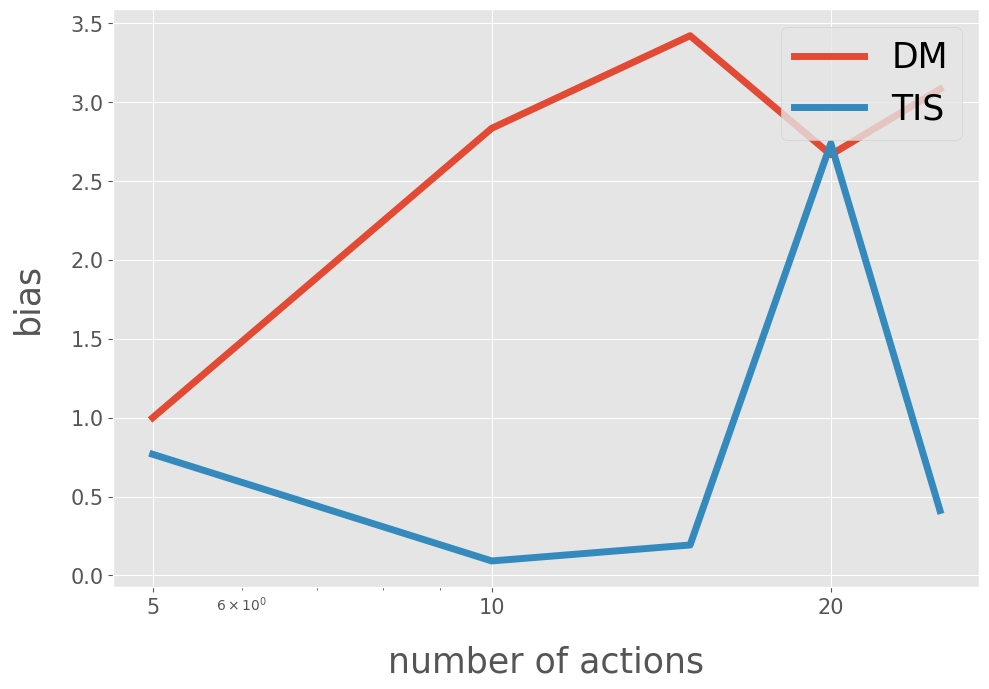

In [15]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5, 10, 20]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_actions",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of actions", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_17161/2403509329.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


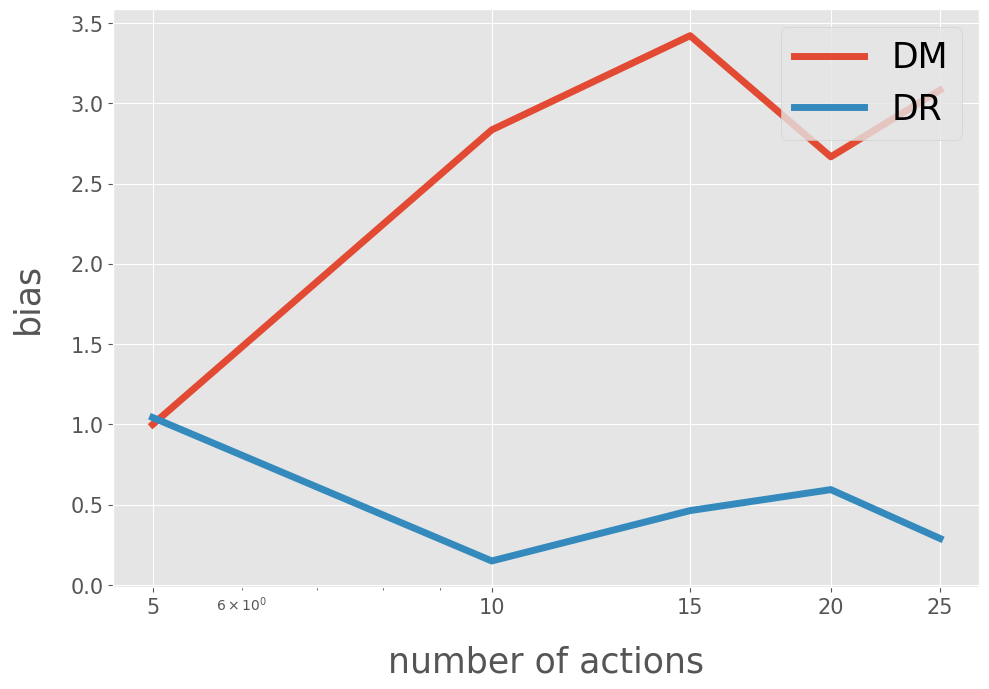

In [28]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5, 10, 15, 20, 25]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_actions",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of actions", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [17]:
variance_result_df

,index,level_1,variance,n_actions
0,on_policy,0,0.000192,5
1,dm,0,0.012965,5
2,tis,0,1.831972,5
3,pdis,0,5.579181,5
4,dr,0,3.875301,5
5,sntis,0,0.033592,5
6,snpdis,0,0.001176,5
7,sndr,0,0.001084,5
8,drl,0,0.012965,5
9,on_policy,0,0.001114,10


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_17161/1318210698.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


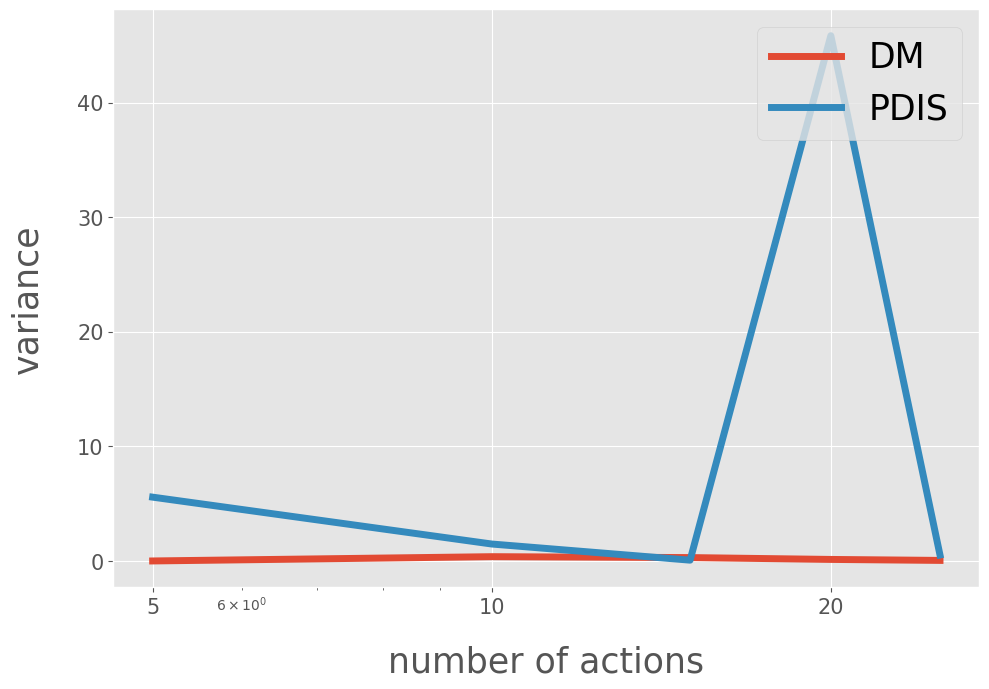

In [18]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5, 10, 20]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_actions",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of actions", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

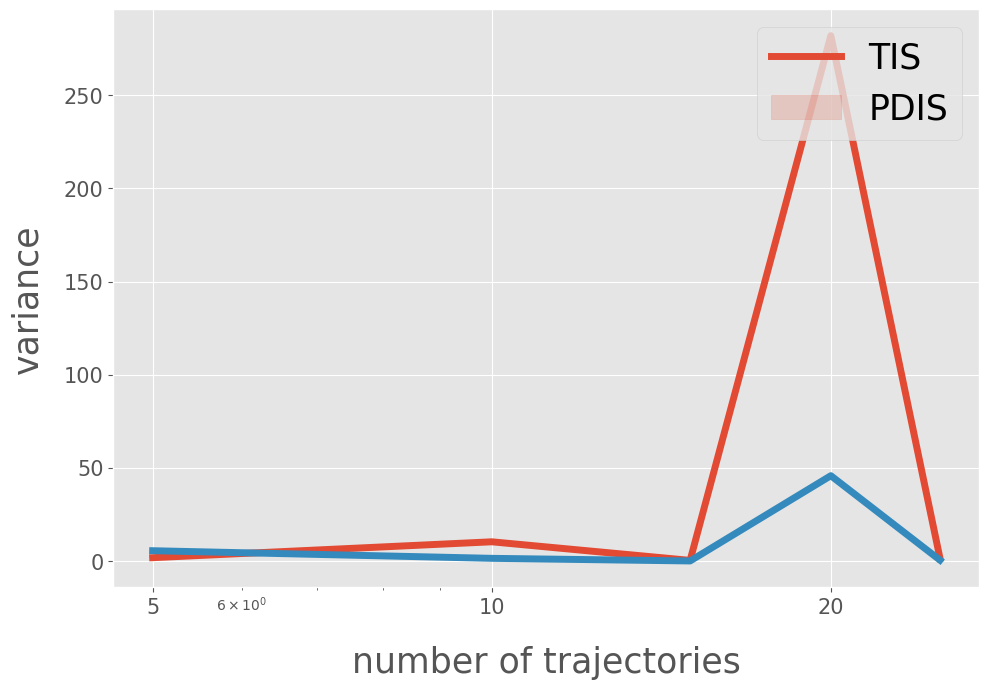

In [25]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5, 10, 20]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_actions",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'pdis')"),
    errorbar=('ci', 95),
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_17161/2855325246.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


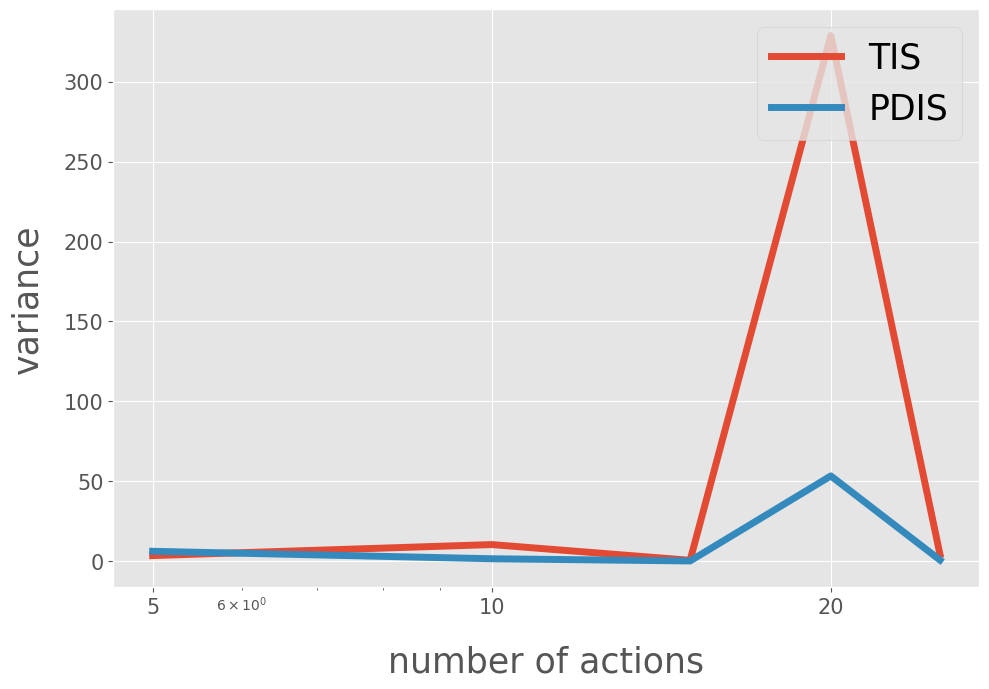

In [29]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5, 10, 20]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_actions",
    y="mse",
    hue="index",
    ax=ax,
    data=mse_result_df.query("(index == 'tis' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of actions", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)